In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression

In [2]:
# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)

In [3]:
# Load dataset
raw = pd.read_csv(
    'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
    index_col='date',
)

raw.tail(5)

FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

In [ ]:
# Dropping store and item columns.
sales = raw[['sales']]

In [ ]:
# Converting date to Month period ans sum the number of itesm in each month.
sales = sales.resample('M').sum()

In [ ]:
sales.head()

,sales
date,
2013-01-31,10327625.0
2013-02-28,9658960.0
2013-03-31,11428497.0
2013-04-30,10993465.0
2013-05-31,11597704.0


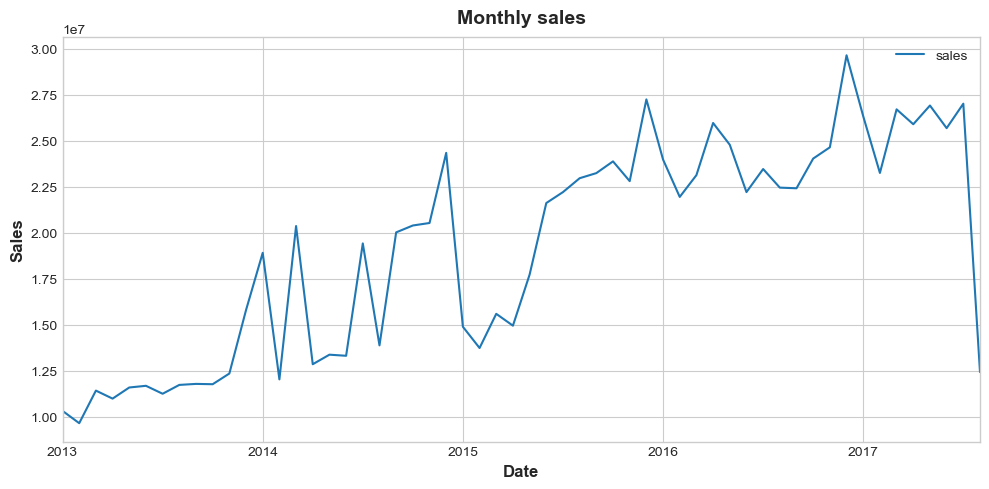

In [ ]:
# Plotting the sales
sales.plot(figsize=(10,5))
plt.ylabel('Sales')
plt.xlabel('Date')
plt.title('Monthly sales');

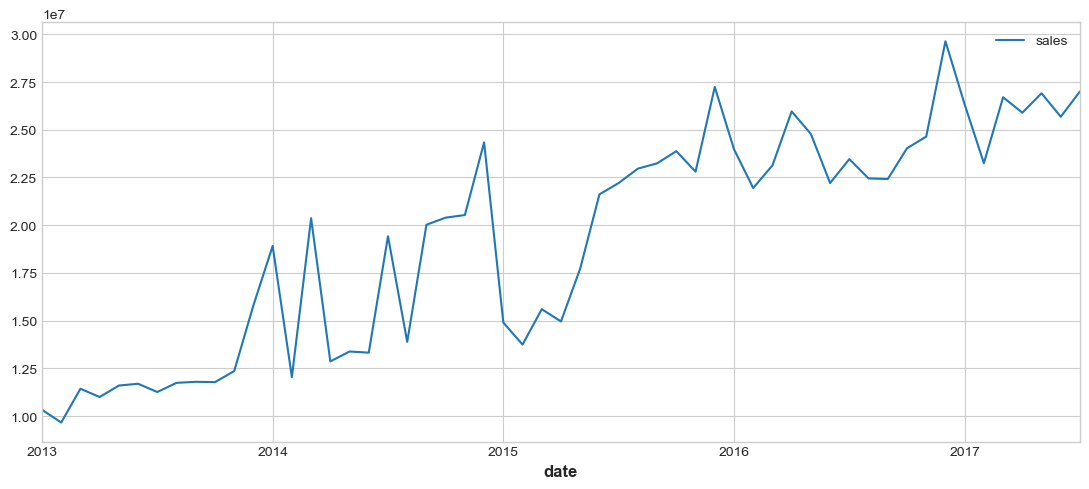

In [ ]:
data = sales.drop(sales.tail(1).index)
data.plot();

# Linear Regression

In [ ]:
# Seasonal plot
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax

In [ ]:
# Periodogram
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

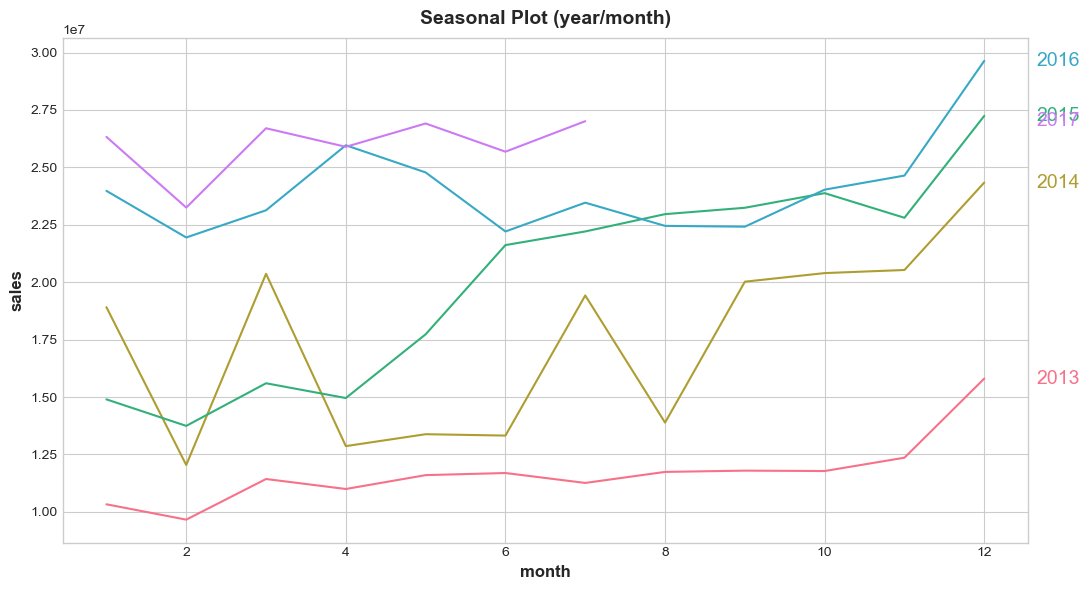

In [ ]:
X = data.copy()

X['month'] = X.index.month
X['year'] = X.index.year

fig, ax = plt.subplots(1, 1, figsize=(11, 6))
seasonal_plot(X, y='sales', period='year', freq='month', ax=ax);


C:\Users\RoccoJustice\AppData\Local\Temp\ipykernel_18104\1466452657.py:1: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  plot_periodogram(data['sales']);


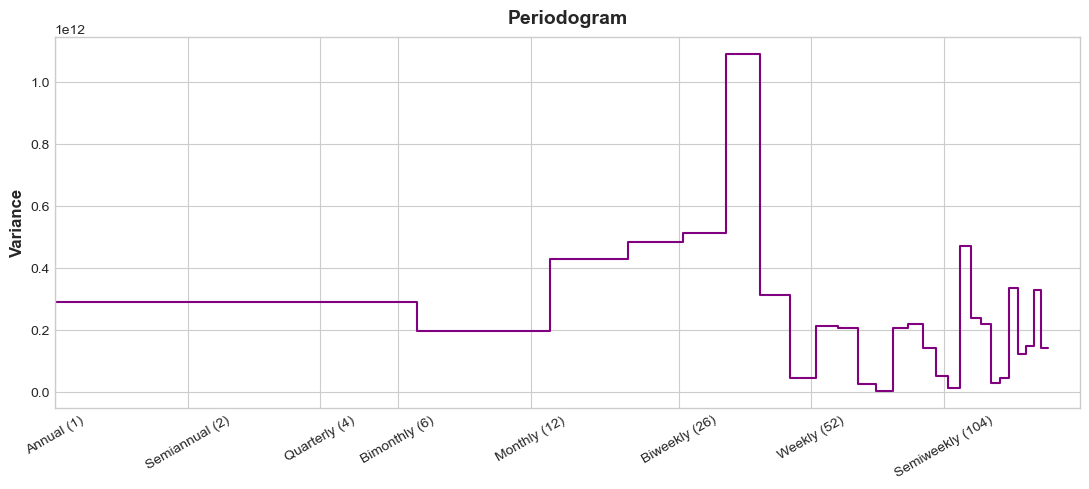

In [ ]:
plot_periodogram(data['sales']);

In [ ]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)

dp = DeterministicProcess(
    index=data.index,
    constant=True,               
    order=1,                     
    seasonal=True,               
    additional_terms=[fourier],  
    drop=True,                   
)

X = dp.in_sample()

In [ ]:
# Splitting the data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, data, test_size=7, shuffle=False)

In [ ]:
# Fitting the model
model = LinearRegression(fit_intercept=False)
results = model.fit(X_train, y_train)

y_fit = pd.Series(results.predict(X_train).reshape(-1), index=X_train.index)
y_pred = pd.Series(results.predict(X_test).reshape(-1), index=X_test.index)


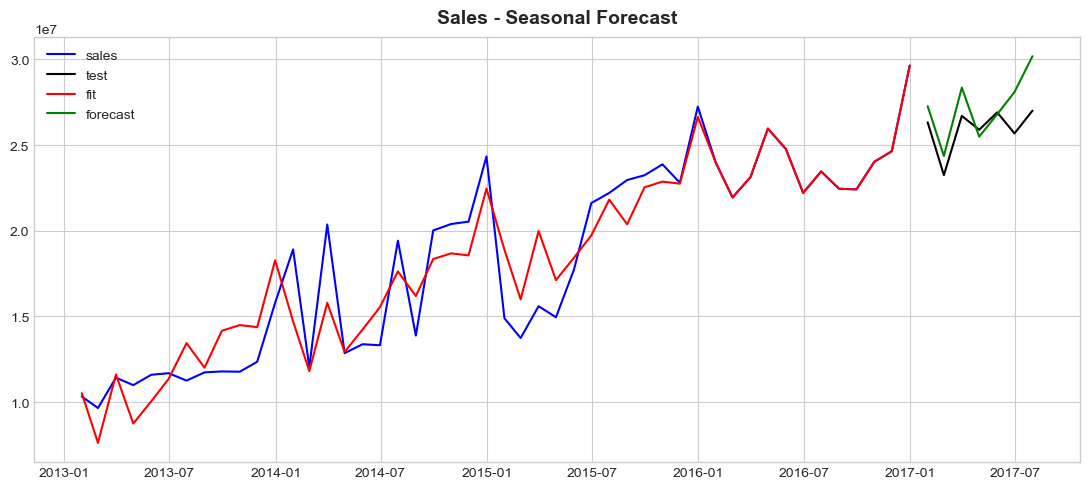

In [ ]:
fig = plt.figure()
plt.plot(y_train.index, y_train, color='blue', label='sales')
plt.plot(y_test.index, y_test, color='black', label = 'test')
plt.plot(y_fit.index, y_fit, color='red', label='fit')
plt.plot(y_pred.index, y_pred, color='green', label='forecast')
plt.title('Sales - Seasonal Forecast')
plt.legend()
plt.show();

In [ ]:
# Calculating error
from sklearn.metrics import mean_squared_error as MSE

mse = MSE(y_test, y_pred) ** 0.5
mse

1730745.4074053904